<a href="https://colab.research.google.com/github/rweidinger/dogapp/blob/dev/GPU_Puppy_Party.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Net for Dog Image Recognition

## Environment Setup

Import libraries and mount Drive

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

In [0]:
import os
import pandas as pd
import numpy as np
from sklearn import neural_network
import scipy.io as sio
import tarfile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical
from PIL import Image
import matplotlib.pyplot as plt
import random as rn
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.2145859409999957
GPU (s):
0.09808400599999345
GPU speedup over CPU: 32x


## Import train and test data

In [0]:
# Define function to download .mat files
def loadMatFile(file_name):
  root_path = 'drive/My Drive/DogApp/'
  return sio.loadmat(root_path + file_name)

In [0]:
# Import train and test sets
train_dict = loadMatFile('train_data.mat')
test_dict = loadMatFile('test_data.mat')
train_data = train_dict['train_data']
test_data = test_dict['test_data']

## Exploratory Data Analysis

In [0]:
train_dict

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Mar 28 12:03:37 2012',
 '__version__': '1.0',
 'train_data': array([[1.        , 0.37021212, 0.38627623, ..., 0.21216631, 0.33752761,
         0.26825407],
        [0.37021212, 1.        , 0.45434285, ..., 0.14359524, 0.3095    ,
         0.17709522],
        [0.38627623, 0.45434285, 1.        , ..., 0.16968838, 0.28702648,
         0.20437348],
        ...,
        [0.21216631, 0.14359524, 0.16968838, ..., 1.        , 0.22314713,
         0.41941136],
        [0.33752761, 0.3095    , 0.28702648, ..., 0.22314713, 1.        ,
         0.31585238],
        [0.26825407, 0.17709522, 0.20437348, ..., 0.41941136, 0.31585238,
         1.        ]]),
 'train_fg_data': array([[4.32900433e-04, 2.88600289e-04, 2.88600289e-04, ...,
         3.96825397e-04, 3.24675325e-04, 2.30880231e-03],
        [0.00000000e+00, 6.34920635e-04, 6.98412698e-04, ...,
         1.90476190e-04, 3.17460317e-05, 4.09523810e-03],

In [0]:
train_data[100].shape

(12000,)

In [0]:
train_data.shape

(12000, 12000)

In [0]:
test_data.shape

(8580, 12000)

In [0]:
test_data[0].shape

(12000,)

In [0]:
fpath = "../input/images/Images/"
random_seed = 42

categories = os.listdir(fpath)
categories = categories[:20]
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

In [0]:
img = Image.fromarray(test_data[0].reshape(32,32,3), 'RGB') 

ValueError: ignored

IndexError: ignored

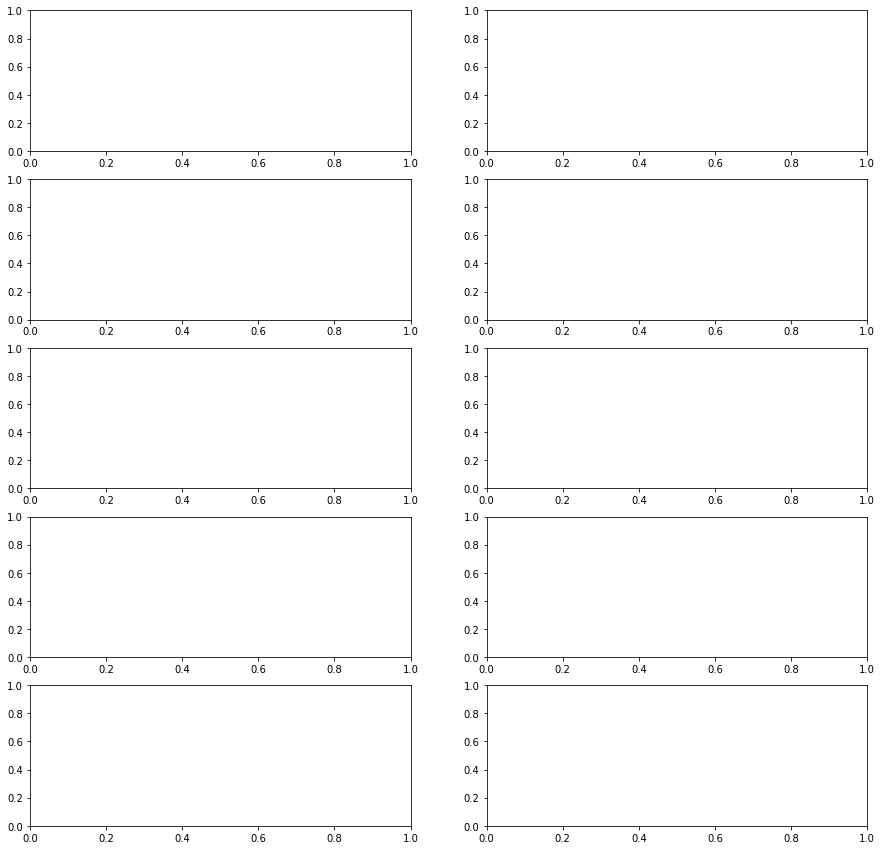

In [0]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Dog: '+Z[l])
        
plt.tight_layout()

## Model Instantiation

In [0]:
MLPC_nn = neural_network.MLPClassifier()